# Bonsai Algorithm

The [Bonsai Algorithm](10.1103/PRXQuantum.4.030314) provides a method to create a TernaryTree encoding with the same toplogy as a target quantum computer.

First we'll define a RustworkX graph representing the topology of the device (this can be obtained from most quantum SDKs.)

Just like the original paper, we'll use a heavy-hex layout with 36 qubits.

In [1]:
import rustworkx as rx
from rustworkx import visualization as rxv
import matplotlib.pyplot as plt
import numpy as np

graph = rx.PyGraph()
graph.add_nodes_from(range(37))
graph.add_edges_from_no_data(
    [
        (0, 1),
        (0, 2),
        (0, 3),
        (1, 4),
        (2, 5),
        (3, 6),
        (4, 7),
        (4, 8),
        (5, 9),
        (5, 10),
        (6, 11),
        (6, 12),
        (7, 13),
        (8, 14),
        (9, 15),
        (10, 16),
        (11, 17),
        (12, 18),
        (13, 19),
        (13, 20),
        (14, 21),
        (14, 22),
        (15, 23),
        (15, 24),
        (16, 25),
        (16, 26),
        (17, 27),
        (17, 28),
        (18, 29),
        (18, 30),
        (22, 31),
        (26, 32),
        (30, 33),
        (31, 34),
        (32, 35),
        (33, 36),
    ]
)

EdgeIndices[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

Let's plot a diagram of the device so we can see it's right.

(This bit looks complicated but it's just to plot a nice-looking diagram so you can safely itnore it)

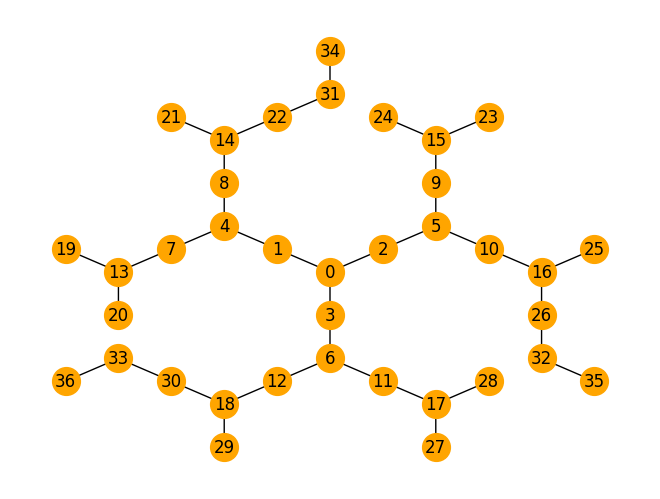

In [2]:
r = np.array([0, -1]) * np.sqrt(1 / graph.num_nodes())
s = np.array([1 * np.sin(45), np.cos(45)]) * np.sqrt(1 / graph.num_nodes())
q = np.array([-1 * np.sin(45), np.cos(45)]) * np.sqrt(1 / graph.num_nodes())
pos = {
    0: [0, 0],
    1: q,
    2: s,
    3: r,
    4: 2 * q,
    5: 2 * s,
    6: 2.0 * r,
    7: 2 * q - s,
    8: 2 * q - r,
    9: 2 * s - r,
    10: 2 * s - q,
    11: 2 * r - q,
    12: 2 * r - s,
    13: 2 * (q - s),
    14: 2 * q - 2 * r,
    15: 2 * s - 2 * r,
    16: 2 * s - 2 * q,
    17: 2 * (r - q),
    18: 2 * r - 2 * s,
    19: 3 * q - 2 * s,
    20: 2 * (q - s) + r,
    21: 3 * q - 2 * r,
    22: 2 * (q - r) + s,
    23: 2 * (s - r) + s,
    24: 2 * (s - r) + q,
    25: 3 * s - 2 * q,
    26: 2 * (s - q) + r,
    27: 3 * r - 2 * q,
    28: 2 * r - 2 * q + s,
    29: 3 * r - 2 * s,
    30: 2 * (r - s) + q,
    31: 2 * q - 2 * r + 2 * s,
    32: 2 * (s - q + r),
    33: 2 * (r - s + q),
    34: 2 * q - 3 * r + 2 * s,
    35: 2 * (s - q + r) - q,
    36: 2 * (r - s + q) - s,
}
pos = rx.spring_layout(graph, pos=pos, fixed={*range(graph.num_nodes())})
rxv.mpl_draw(graph, with_labels=True, pos=pos, node_color="orange", node_size=400)

## Root node

The root node is set as the node for which its longest path is the shortest of all the nodes' longest paths.

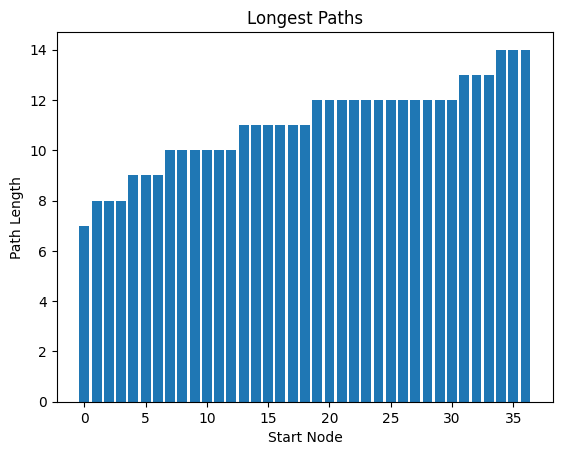

In [3]:
distances = rx.distance_matrix(graph)
plt.bar([*range(distances.shape[1])], np.max(distances, axis=1))
plt.title("Longest Paths")
plt.xlabel("Start Node")
plt.ylabel("Path Length")
plt.show()

So for this graph, node 0 has the shortest path length and is therefore the root of the tree.

To implement the algorithm, we'll build the graph out of Ternary Tree Nodes from `ferrmion`. By doing this, making an encoding from the graph is as simple as passing the root node to a `ferrmion.TernaryTree`. 

In [4]:
from ferrmion.encode.ternary_tree_node import TTNode
from enum import Enum
import numpy as np

# First we find the root
root_index = np.argmin(np.max(distances, axis=1))
node_queue = [root_index]
used_indices = {root_index}

# Set values for the root node.
nodes = [TTNode(parent=None) for _ in range(graph.num_nodes())]
nodes[root_index].root_path = ""
nodes[root_index].qubit_label = root_index

## Labelling Scheme

At this point it's useful to define a preference for which branch we want to assign new nodes to.

In the original paper there are two methods, which assign each of X, Y and Z in order of prefernce:
- Homogeneous: [X, Y, Z]
- Heterogenous: [Z, X, Y]

In [5]:
class LabellingTypes(Enum):
    HOM = "homogenous"
    HET = "heterogenous"


labelling = LabellingTypes("homogenous")

## Building the Tree

To build the tree, we follow a bredth-first search, adding child nodes to each parent in the order defined by the Labelling type we have used.

In [6]:
while len(node_queue) > 0:
    node = node_queue.pop(0)
    parent = nodes[node]

    match labelling:
        case LabellingTypes.HOM:
            chars = ["x", "y", "z"]
        case LabellingTypes.HET:
            chars = ["z", "x", "y"]

    neighbors = list(set(graph.neighbors(node)).difference(used_indices))

    for child in neighbors[:3]:
        node_queue.append(child)
        used_indices.add(child)

    n_neighbors = len(neighbors)
    for neighbor, char in zip(neighbors[:3], chars[:n_neighbors]):
        parent.add_child(
            char,
            child_node=nodes[neighbor],
            root_path=f"{parent.root_path}{char}",
            qubit_label=neighbor,
        )
        nodes[neighbor].parent = parent

### Orphaned Nodes

At this point we need to check if the tree covers all the nodes of our original graph (i.e. the tree _spans_ the graph).

If not, then we attach orphaned nodes to the node closest to it which has space for another child.

In [7]:
if len(used_indices) == graph.num_nodes():
    print("Tree spans the graph!")
else:
    print("Tree does not span the graph!")
    unused_indices = set(range(graph.num_nodes())).difference(used_indices)
    for unused in unused_indices:
        closest = np.argsort(distances[unused])
        for used in closest:
            used_node: TTNode = nodes[used]
            for child_branch in chars:
                if getattr(used_node, child_branch) is None:
                    used_node.add_child(
                        child_branch,
                        child_node=nodes[unused],
                        root_path=f"{used_node.root_path}{child_branch}",
                        qubit_label=unused,
                    )
                    unused_indices.remove(used)
                    break
    if len(unused_indices) > 0:
        print("Error, not all qubits assigned to nodes.")

Tree spans the graph!


## Creating an Encoding

Now we can create a `TernaryTree` encoding from the root node.

In [8]:
from ferrmion import TernaryTree

bonsai = TernaryTree(graph.num_nodes(), root_node=nodes[root_index])
bonsai.enumeration_scheme = bonsai.default_enumeration_scheme()

Let's see what this encoding looks like

In [9]:
from ferrmion.visualise import draw_tt

draw_tt(bonsai, enumeration_scheme=bonsai.enumeration_scheme)

# Inbuilt Function

There is an in-built function in `ferrmion`, we only need to pass the initial graph.

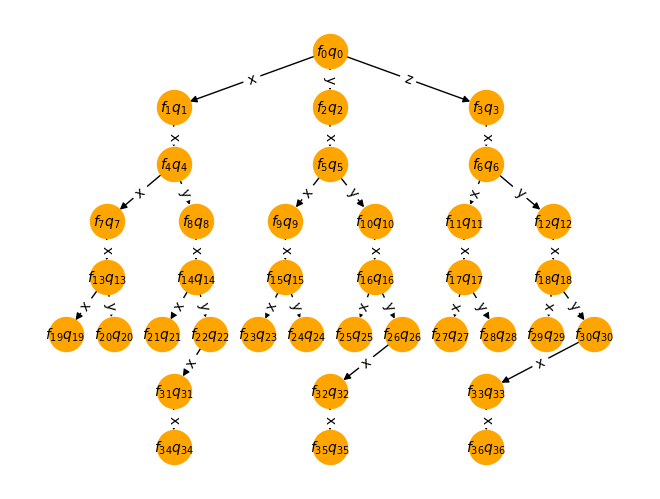

In [10]:
from ferrmion.optimize.bonsai import bonsai_algorithm

bonsai = bonsai_algorithm(graph=graph, homogenous=True)
draw_tt(bonsai, enumeration_scheme=bonsai.enumeration_scheme)

or the heterogenous labelling, and optionally a maximum number of nodes

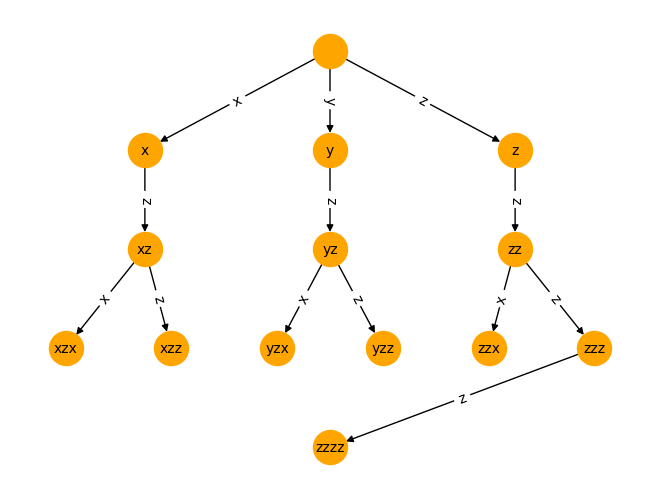

In [11]:
bonsai = bonsai_algorithm(graph=graph, homogenous=False, max_nodes=14)
draw_tt(bonsai)

# Encoding a Hamiltonian

In [12]:
import json
from ferrmion.encode import TernaryTree, MaxNTO
from pathlib import Path

folder = Path.cwd().joinpath(Path("../../../python/tests/"))
with open(folder.joinpath("./data/h2o_sto-3g.json"), "rb") as file:
    data = json.load(file)
ones = np.array(data["ones"])
twos = np.array(data["twos"])

In [13]:
from ferrmion.hamiltonians import molecular_hamiltonian

fham = molecular_hamiltonian(ones, twos, 0.0)
bonsai.encode(fham)

{'YZZXXXZIYIXXII': (-0.015251288901414455+0j),
 'XZZXZIIXIIIIII': (3.4447415218334567e-07+0j),
 'YZXXZIZZIIIZIY': (3.9060932224181344e-08+0j),
 'IIIIZIIIZIIZII': (-0.1194986931119835+0j),
 'YZZIZZZYIZIIZI': (5.88758398825461e-09+0j),
 'YXIIIXIIIIYIII': (-0.02707115378387988+0j),
 'YZZIIZIZYZIIIX': (1.576519939186647e-08+0j),
 'XZIZXIIIZIIZZI': (0.0016049614613082557+0j),
 'ZIIZIZZIIZIXII': (-0.05863955340699901+0j),
 'ZYZXXXIIYIZIII': (-5.1679058741694396e-08+0j),
 'XYIXIYIIIZXIII': (-0.0022886102997761895+0j),
 'YZZIZZIYIZIZII': (1.505432923495098e-08+0j),
 'ZIZZIXXIIXYIYI': (-0.0033478980733706813+0j),
 'IIIIYIIZXIIIIY': (-2.3702939314246254e-07+0j),
 'IIIIZIIIXIXIII': (-2.6857132619785154e-08+0j),
 'YZZIYXIIIZZIII': (3.074183777810703e-08+0j),
 'YZZXXZXIXYIIXI': (-0.014616837616021673+0j),
 'ZYZZZZZZIZIZIY': (3.4447415218334567e-07+0j),
 'YZYIXIIIXIIIII': (-0.07170028934810822+0j),
 'YZZIXYIZZIIIII': (-1.1530426358281644e-09+0j),
 'XZIZXYXIYYZIYI': (-2.9037494294204896e-08+0j),
 'II